In [202]:
from notebooks.imports import *

# import pandas as pd
# import spacy
# import numpy as np
# from nltk.sentiment import SentimentIntensityAnalyzer
# import os
# os.chdir('../')
# from src.features.preprocess import PreProcess
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN

# 1. Preprocess

In [203]:
def preprocess(df, col):
    preprocessor = PreProcess()
    preprocessor.fill_na(df, col)
    preprocessor.remove_urls(df, col)
    preprocessor.expand_contractions(df, col)
    preprocessor.remove_escape_chars(df, col)
    return df

In [204]:
subreddit = "computerscience"

In [205]:
world_posts = pd.read_csv('../data/raw/{}_new_posts.csv'.format(subreddit))
world_comments = pd.read_csv('../data/raw/{}_new_comments.csv'.format(subreddit))

In [206]:
world_posts

,post_id,title,score,upvote_ratio,subreddit,url,num_comments,body,created
0,sko30v,application with a database,0,0.50,computerscience,https://www.reddit.com/r/computerscience/comme...,0,Hello! I am trying to create a dictionary appl...,1.644008e+09
1,skm1fx,Starting classes for Computer science on Monda...,0,0.33,computerscience,https://www.reddit.com/r/computerscience/comme...,0,NaN,1.644003e+09
2,skltie,Confusion Between Different Types of Optimizat...,8,1.00,computerscience,https://www.reddit.com/r/computerscience/comme...,1,I do not have a background in optimization and...,1.644002e+09
3,sklhet,How to I get my code to a stand-alone computer...,0,0.25,computerscience,https://www.reddit.com/r/computerscience/comme...,9,How to I get my code to a stand-alone computer...,1.644002e+09
4,skkubm,How is the computer science education quality ...,0,0.33,computerscience,https://www.reddit.com/r/computerscience/comme...,7,"Im 26. As a candidate international student, a...",1.644000e+09
...,...,...,...,...,...,...,...,...,...
834,otb7nh,"Question about AWS blog post's use of ""Hard Re...",25,0.93,computerscience,https://www.reddit.com/r/computerscience/comme...,5,In [this AWS Builder's Library post](https://a...,1.627483e+09
835,ot25cm,How do smart devices get registered to a backend?,42,0.94,computerscience,https://www.reddit.com/r/computerscience/comme...,11,"Hi all, I don't know if this is the right plac...",1.627444e+09
836,osxojq,how to efficiently learn machine language or c...,0,0.44,computerscience,https://www.reddit.com/r/computerscience/comme...,4,I am assuming there are many ways to learn the...,1.627428e+09
837,osn6iv,Which chapters should I skip for OSTEP (Operat...,0,0.31,computerscience,https://www.reddit.com/r/computerscience/comme...,6,I will soon start my graduate software enginee...,1.627394e+09


In [207]:
world_comments

,post_id,comment,comment_id,parent_id,created,is_submitter
0,skltie,1) yes they are basically the same things. The...,hvlyn6o,t3_skltie,1.644007e+09,False
1,sklhet,What language is your code in?,hvm3b74,t3_sklhet,1.644009e+09,False
2,sklhet,It can be in any of the common languages.,hvm5e7x,t1_hvm3b74,1.644010e+09,True
3,sklhet,What kind of chip? Is this an embedded device ...,hvm3sh3,t3_sklhet,1.644009e+09,False
4,sklhet,I have no idea. The usb inputs are coming from...,hvm5sqa,t1_hvm3sh3,1.644010e+09,True
...,...,...,...,...,...,...
9970,osn6iv,"Since you are just looking to do a fly by, i w...",h6r39bl,t3_osn6iv,1.627420e+09,False
9971,osn6iv,Only “textbook” in college I read cover-to-cov...,h6r3q0o,t3_osn6iv,1.627420e+09,False
9972,osn6iv,Thanks!,h6rby6c,t1_h6r3q0o,1.627424e+09,False
9973,oscvji,Buy an Arduino starter kit and start messing a...,h6q6dsz,t3_oscvji,1.627405e+09,False


In [208]:
def body_length(s):
    return len(s.split(" "))

In [209]:
posts_df = world_posts.drop(columns=["subreddit", "url","title", "created"])
posts_df = posts_df.dropna()
posts_df["body_length"] = posts_df["body"].apply(body_length)
preprocess(posts_df, "body")
posts_df.head()

,post_id,score,upvote_ratio,num_comments,body,body_length
0,sko30v,0,0.50,0,Hello! I am trying to create a dictionary appl...,56
2,skltie,8,1.00,1,I do not have a background in optimization and...,548
3,sklhet,0,0.25,9,How to I get my code to a stand-alone computer...,24
4,skkubm,0,0.33,7,"I Am 26. As a candidate international student,...",34
5,skkkmf,1,1.00,4,"If we ran 10,000,000 cycles would we see a mil...",19


<AxesSubplot:>

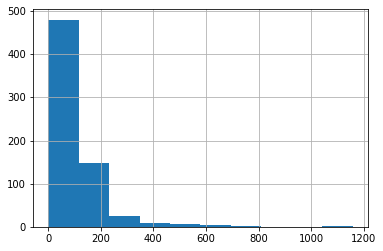

In [210]:
posts_df.body_length.hist()

**NOTE: Shows that most posts have less than 200 words which is very less when considered as a document.**

In [211]:
comments_df = world_comments.copy()
comments_df["body_length"] = comments_df["comment"].apply(body_length)
preprocess(comments_df, "comment")
comments_df.head()

,post_id,comment,comment_id,parent_id,created,is_submitter,body_length
0,skltie,1) yes they are basically the same things. The...,hvlyn6o,t3_skltie,1.644007e+09,False,149
1,sklhet,What language is your code in?,hvm3b74,t3_sklhet,1.644009e+09,False,6
2,sklhet,It can be in any of the common languages.,hvm5e7x,t1_hvm3b74,1.644010e+09,True,9
3,sklhet,What kind of chip? Is this an embedded device ...,hvm3sh3,t3_sklhet,1.644009e+09,False,12
4,sklhet,I have no idea. The usb inputs are coming from...,hvm5sqa,t1_hvm3sh3,1.644010e+09,True,25


<AxesSubplot:>

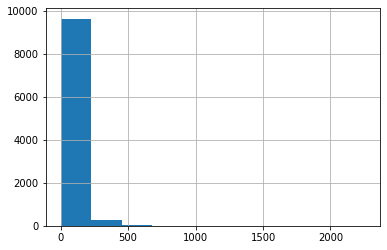

In [212]:
comments_df.body_length.hist()

# 2. Topic Modeling - POSTS

In [213]:
posts_df['body'] = posts_df['body'].astype(str)
body_df = posts_df[posts_df['body'] != 'nan']
body_df = body_df.reset_index()
body_df

,index,post_id,score,upvote_ratio,num_comments,body,body_length
0,0,sko30v,0,0.50,0,Hello! I am trying to create a dictionary appl...,56
1,2,skltie,8,1.00,1,I do not have a background in optimization and...,548
2,3,sklhet,0,0.25,9,How to I get my code to a stand-alone computer...,24
3,4,skkubm,0,0.33,7,"I Am 26. As a candidate international student,...",34
4,5,skkkmf,1,1.00,4,"If we ran 10,000,000 cycles would we see a mil...",19
...,...,...,...,...,...,...,...
673,834,otb7nh,25,0.93,5,In [this AWS Builder's Library post](-library/...,269
674,835,ot25cm,42,0.94,11,"Hi all, I do not know if this is the right pla...",151
675,836,osxojq,0,0.44,4,I am assuming there are many ways to learn the...,106
676,837,osn6iv,0,0.31,6,I will soon start my graduate software enginee...,72


In [214]:
# body_umap_params = {
#     'n_neighbors':5,
#     'n_components': 5,
#     'min_dist': 0.0,
#     'metric': 'cosine',
#     'low_memory': False
# }
# body_hdb_params = {
#     'min_cluster_size': 5,
#     'min_samples': 4,
#     'metric': 'euclidean',
#     'cluster_selection_method': 'eom',
#     'prediction_data': True
# }
# body_model_params = {
#     'min_topic_size': 3,
#     'top_n_words': 5,
#     'n_gram_range': (1,2), 
#     'calculate_probabilities': True,
#     'verbose': True
# }

In [215]:
# def train_bert(df, column, umap_params={}, hdb_params={}, model_params={}):
#     umap_model = UMAP(**umap_params)
#     hdbscan_model = HDBSCAN(**hdb_params)
#     topic_model = BERTopic(**model_params, umap_model=umap_model, hdbscan_model=hdbscan_model)
#     topic_model = BERTopic(**model_params)
#     topics, probs = topic_model.fit_transform(df[column])
#     freq = topic_model.get_topic_info()
#     docs = topic_model.get_representative_docs()
#     topic_names = []
#     for i in topics:
#         topic_names.append(list(freq[freq['Topic'] == i]["Name"])[0])
#     df['topic_label'] = topics
#     df['topic_name'] = topic_names
#     return topic_model, freq, df

In [216]:
docs = list(body_df.body)

In [217]:
docs

['Hello! I am trying to create a dictionary application where you can enter a word and get a translation.(only 2 languages)So my question is if I use a database like SQLite, when the user downloads my application they do not have to download any additional things because the SQLite database would be packaged with the application, right?',
 'I do not have a background in optimization and I am trying to teach myself more about this topic. I find myself having a lot of trouble understanding the different "types" of optimization problems that exist.For example, I understand the idea of optimizing continuous functions (e.g. y = x\\^2) - for example, we could be interested in finding out the value of "x" that results in the smallest value of "y". I also understand that continuous functions can be optimized subject to some constraints.However, I find myself very confused when trying to sort through the following types of optimization problems:* **Discrete Optimization*** **Integer Optimizatio

In [218]:
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(docs)

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

2022-02-14 12:15:29,577 - BERTopic - Transformed documents to Embeddings
2022-02-14 12:15:32,632 - BERTopic - Reduced dimensionality with UMAP
2022-02-14 12:15:32,667 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [219]:
freq = topic_model.get_topic_info()
freq.head(5)

,Topic,Count,Name
0,-1,237,-1_the_to_and_is
1,0,153,0_to_and_am_for
2,1,63,1_the_to_is_and
3,2,39,2_the_to_of_it
4,3,39,3_memory_the_is_of


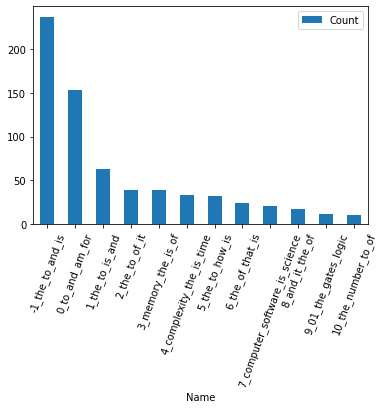

In [220]:
freq.plot(kind='bar', x='Name', y='Count', rot=70)
plt.show()

In [221]:
topic_model.visualize_topics()

In [222]:
topic_model.visualize_distribution(probs[200], min_probability=0.015)

In [223]:
topic_model.visualize_barchart(top_n_topics=5)

**The topics are meaningless and contain a lot of stopwords showing as most important, this could be due to there being less words in each post resulting in more importance for more frequent stopwords. Let's preprocess the body further before using BERTopic**

In [167]:
body_df

,index,post_id,score,upvote_ratio,num_comments,body,body_length
0,0,sko30v,0,0.50,0,Hello! I am trying to create a dictionary appl...,56
1,2,skltie,8,1.00,1,I do not have a background in optimization and...,548
2,3,sklhet,0,0.25,9,How to I get my code to a stand-alone computer...,24
3,4,skkubm,0,0.33,7,"I Am 26. As a candidate international student,...",34
4,5,skkkmf,1,1.00,4,"If we ran 10,000,000 cycles would we see a mil...",19
...,...,...,...,...,...,...,...
673,834,otb7nh,25,0.93,5,In [this AWS Builder's Library post](-library/...,269
674,835,ot25cm,42,0.94,11,"Hi all, I do not know if this is the right pla...",151
675,836,osxojq,0,0.44,4,I am assuming there are many ways to learn the...,106
676,837,osn6iv,0,0.31,6,I will soon start my graduate software enginee...,72


In [168]:
prep = PreProcess()
prep.fill_na(body_df, 'body')
prep.remove_urls(body_df, 'body')
prep.expand_contractions(body_df, 'body')
prep.to_lower(body_df, 'body')

prep.tokenize(body_df, 'body')
prep.filter_stopwords(body_df, 'body')
prep.lemm(body_df, 'body')

,index,post_id,score,upvote_ratio,num_comments,body,body_length,body_word_token,body_tag
0,0,sko30v,0,0.50,0,hello! i am trying to create a dictionary appl...,56,"[hello, !, try, create, dictionary, applicatio...","[[(hello, NN)], [(!, .)], [(trying, VBG)], [(c..."
1,2,skltie,8,1.00,1,i do not have a background in optimization and...,548,"[background, optimization, try, teach, topic, ...","[[(background, NN)], [(optimization, NN)], [(t..."
2,3,sklhet,0,0.25,9,how to i get my code to a stand-alone computer...,24,"[get, code, stand-alone, computer, chip, ?, ch...","[[(get, VB)], [(code, NN)], [(stand-alone, NN)..."
3,4,skkubm,0,0.33,7,"i am 26. as a candidate international student,...",34,"[26., candidate, international, student, ,, mi...","[[(26., CD)], [(candidate, NN)], [(internation..."
4,5,skkkmf,1,1.00,4,"if we ran 10,000,000 cycles would we see a mil...",19,"[ran, 10,000,000, cycle, would, see, million, ...","[[(ran, NN)], [(10,000,000, CD)], [(cycles, NN..."
...,...,...,...,...,...,...,...,...,...
673,834,otb7nh,25,0.93,5,in [this aws builder's library post](-library/...,269,"[[, aws, builder, 's, library, post, ], (, -li...","[[([, NN)], [(aws, NNS)], [(builder, NN)], [('..."
674,835,ot25cm,42,0.94,11,"hi all, i do not know if this is the right pla...",151,"[hi, ,, know, right, place, ask, question, ,, ...","[[(hi, NN)], [(,, ,)], [(know, VB)], [(right, ..."
675,836,osxojq,0,0.44,4,i am assuming there are many ways to learn the...,106,"[assume, many, way, learn, machine, language, ...","[[(assuming, VBG)], [(many, JJ)], [(ways, NNS)..."
676,837,osn6iv,0,0.31,6,i will soon start my graduate software enginee...,72,"[soon, start, graduate, software, engineering,...","[[(soon, RB)], [(start, NN)], [(graduate, NN)]..."


In [169]:
body_df['body_string'] = body_df['body_word_token'].apply(lambda x: ' '.join(map(str, x)))
body_df

,index,post_id,score,upvote_ratio,num_comments,body,body_length,body_word_token,body_tag,body_string
0,0,sko30v,0,0.50,0,hello! i am trying to create a dictionary appl...,56,"[hello, !, try, create, dictionary, applicatio...","[[(hello, NN)], [(!, .)], [(trying, VBG)], [(c...",hello ! try create dictionary application ente...
1,2,skltie,8,1.00,1,i do not have a background in optimization and...,548,"[background, optimization, try, teach, topic, ...","[[(background, NN)], [(optimization, NN)], [(t...",background optimization try teach topic . find...
2,3,sklhet,0,0.25,9,how to i get my code to a stand-alone computer...,24,"[get, code, stand-alone, computer, chip, ?, ch...","[[(get, VB)], [(code, NN)], [(stand-alone, NN)...",get code stand-alone computer chip ? chip need...
3,4,skkubm,0,0.33,7,"i am 26. as a candidate international student,...",34,"[26., candidate, international, student, ,, mi...","[[(26., CD)], [(candidate, NN)], [(internation...","26. candidate international student , middle l..."
4,5,skkkmf,1,1.00,4,"if we ran 10,000,000 cycles would we see a mil...",19,"[ran, 10,000,000, cycle, would, see, million, ...","[[(ran, NN)], [(10,000,000, CD)], [(cycles, NN...","ran 10,000,000 cycle would see million digit ,..."
...,...,...,...,...,...,...,...,...,...,...
673,834,otb7nh,25,0.93,5,in [this aws builder's library post](-library/...,269,"[[, aws, builder, 's, library, post, ], (, -li...","[[([, NN)], [(aws, NNS)], [(builder, NN)], [('...",[ aws builder 's library post ] ( -library/cha...
674,835,ot25cm,42,0.94,11,"hi all, i do not know if this is the right pla...",151,"[hi, ,, know, right, place, ask, question, ,, ...","[[(hi, NN)], [(,, ,)], [(know, VB)], [(right, ...","hi , know right place ask question , hope help..."
675,836,osxojq,0,0.44,4,i am assuming there are many ways to learn the...,106,"[assume, many, way, learn, machine, language, ...","[[(assuming, VBG)], [(many, JJ)], [(ways, NNS)...","assume many way learn machine language , howev..."
676,837,osn6iv,0,0.31,6,i will soon start my graduate software enginee...,72,"[soon, start, graduate, software, engineering,...","[[(soon, RB)], [(start, NN)], [(graduate, NN)]...",soon start graduate software engineering role ...


In [170]:
docs1 = list(body_df.body_string)
len(docs1)

678

In [171]:
topic_model1 = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics1, probs1 = topic_model1.fit_transform(docs1)


Batches:   0%|          | 0/22 [00:00<?, ?it/s]

2022-02-07 22:38:52,379 - BERTopic - Transformed documents to Embeddings
2022-02-07 22:38:54,658 - BERTopic - Reduced dimensionality with UMAP
2022-02-07 22:38:54,700 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [172]:
freq1 = topic_model1.get_topic_info()
freq1.head(5)

,Topic,Count,Name
0,-1,301,-1_computer_would_like_use
1,0,81,0_book_learn_computer_good
2,1,73,1_problem_algorithm_complexity_time
3,2,42,2_language_compiler_program_string
4,3,36,3_hash_ip_server_address


In [173]:
topic_model1.visualize_distribution(probs1[200], min_probability=0.015)

In [174]:
topic_model1.visualize_barchart(top_n_topics=10)

In [175]:
from collections import Counter

Counter(topics1)

Counter({2: 42,
         1: 73,
         -1: 301,
         5: 33,
         0: 81,
         6: 26,
         7: 20,
         3: 36,
         4: 35,
         8: 19,
         9: 12})

## Reducing the number of topics to 5

In [176]:
new_topics, new_probs = topic_model1.reduce_topics(docs1, topics1, probs1, nr_topics=5)

2022-02-07 22:38:55,486 - BERTopic - Reduced number of topics from 11 to 6


In [177]:
topic_model1.update_topics(docs1, topics1, n_gram_range=(1, 3))

In [178]:
topic_model1.visualize_barchart(top_n_topics=10)

In [188]:
posts_df.shape, comments_df.shape

((678, 6), (9975, 8))

# 3. Topic Modeling - COMMENTS

In [185]:
comments_df['body'] = comments_df['comment'].astype(str)
body_df = comments_df[comments_df['body'] != 'nan']
body_df = body_df.reset_index()
body_df

,index,post_id,comment,comment_id,parent_id,created,is_submitter,body_length,body
0,0,skltie,1) yes they are basically the same things. The...,hvlyn6o,t3_skltie,1.644007e+09,False,149,1) yes they are basically the same things. The...
1,1,sklhet,What language is your code in?,hvm3b74,t3_sklhet,1.644009e+09,False,6,What language is your code in?
2,2,sklhet,It can be in any of the common languages.,hvm5e7x,t1_hvm3b74,1.644010e+09,True,9,It can be in any of the common languages.
3,3,sklhet,What kind of chip? Is this an embedded device ...,hvm3sh3,t3_sklhet,1.644009e+09,False,12,What kind of chip? Is this an embedded device ...
4,4,sklhet,I have no idea. The usb inputs are coming from...,hvm5sqa,t1_hvm3sh3,1.644010e+09,True,25,I have no idea. The usb inputs are coming from...
...,...,...,...,...,...,...,...,...,...
9970,9970,osn6iv,"Since you are just looking to do a fly by, i w...",h6r39bl,t3_osn6iv,1.627420e+09,False,66,"Since you are just looking to do a fly by, i w..."
9971,9971,osn6iv,Only “textbook” in college I read cover-to-cov...,h6r3q0o,t3_osn6iv,1.627420e+09,False,22,Only “textbook” in college I read cover-to-cov...
9972,9972,osn6iv,Thanks!,h6rby6c,t1_h6r3q0o,1.627424e+09,False,1,Thanks!
9973,9973,oscvji,Buy an Arduino starter kit and start messing a...,h6q6dsz,t3_oscvji,1.627405e+09,False,9,Buy an Arduino starter kit and start messing a...


# 4. VADER Sentiment Function

In [19]:
def find_sentiment(df, column):
    sia = SentimentIntensityAnalyzer()
    neg_scores = []
    neu_scores = []
    pos_scores = []
    compounds = []
    for i in range(len(df.index)):
        neg_scores.append(sia.polarity_scores(df.at[i, column])['neg'])
        neu_scores.append(sia.polarity_scores(df.at[i, column])['neu'])
        pos_scores.append(sia.polarity_scores(df.at[i, column])['pos'])
        compounds.append(sia.polarity_scores(df.at[i, column])['compound'])
    df['neg_sentiment'] = neg_scores
    df['neu_sentiment'] = neu_scores
    df['pos_sentiment'] = pos_scores
    df['compound_sentiment'] = compounds
    return df

In [20]:
comment_df = find_sentiment(comment_df, 'comment')

In [21]:
final_comment_df = comment_df[['topic_label', 'topic_name', 'neg_sentiment', 'neu_sentiment', 'pos_sentiment', 'compound_sentiment']]

In [22]:
pd.set_option('display.max_rows', None)
final_comment_df.groupby(by=['topic_label', 'topic_name']).mean().reset_index()

,topic_label,topic_name,neg_sentiment,neu_sentiment,pos_sentiment,compound_sentiment
0,-1,-1_the_to_and_you,0.033943,0.857044,0.109044,0.345921
1,0,0_love_awesome_this is_lol,0.044316,0.532816,0.422868,0.458008
2,1,1_algorithms_by_and_the,0.011027,0.861703,0.127270,0.346157
3,2,2_ai_to_human_intelligence,0.050259,0.814407,0.135370,0.314700
4,3,3_bit_to_cpu_the,0.016136,0.931727,0.052136,0.330873
5,4,4_programming pearls_jon_jon bentley_bentley,0.017190,0.931143,0.051714,0.131710
6,5,5_python_cs_learn_programming,0.006789,0.879421,0.113789,0.383400
7,6,6_nft_the_image_nfts,0.024824,0.894176,0.080941,0.379159
8,7,7_math_science_computer science_you,0.013412,0.918588,0.067941,0.233588
9,8,8_software_engineering_computer_engineer,0.013059,0.914471,0.072353,0.369388
